In [1]:
train_on = ['reman', 'gne', 'electoral_tweets'][1]
# set maximum sentence length
maxlen = 100

# import

In [2]:
import pandas as pd
import numpy as np
import collections
from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical   
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, Callback
from transformers import  RobertaTokenizer
from transformers import RobertaConfig, TFRobertaModel
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import *
from keras.optimizers import *
import json

# read data

In [3]:
df = pd.read_json("emotion-rl-corpora-DO-NOT-SHARE.jsonl", lines = True)

In [4]:
# remove unused columns
df = df.drop(columns=['text', 'emotions', 'meta', 'steps', 'tags', 'annotation-offsets', 'split', 'extra'])
# make json to column
df = df.join(df['annotations'].apply(pd.Series))
# remove created unused columns
df = df.drop(columns=['cue-joy', 'cue-sadness', 'cue-anger', 'cue-other', 'cue-disgust', 'cue-trust', 'cue-anticipation', 'cue-surprise', 'cue-fear', 'cue'])
# remove unused columns
df = df.drop(columns=['annotations', 'cause', 'experiencer'])
# drop nan-rows
df = df.dropna()

# preprocessing

In [5]:
print("maximum sentence length", len(max(df["tokens"], key=len)))

maximum sentence length 121


In [6]:
df['dataset'].unique()

array(['reman', 'gne', 'electoral_tweets'], dtype=object)

In [7]:
data_source = df.loc[(df['dataset'] == train_on)]

In [8]:
tag2idx = {t:i for i,t in enumerate(['O', 'B', 'I'])}
idx2tag = {i:t for i,t in enumerate(['O', 'B', 'I'])}

In [9]:
X = data_source["tokens"].to_numpy()
y = data_source["target"].to_numpy()

In [10]:
#X = pad_sequences(X, maxlen, value="__PADWORD__", dtype=object, padding='post')

In [11]:
# pad labels to same lenght
y = pad_sequences(y, maxlen, value='O', dtype=object, padding='post')
y = np.array([[tag2idx[w] for w in s] for s in y])

In [12]:
# count class-occurences
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
# calculate class imbalances
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=np.hstack(y))
class_weights = dict(enumerate(class_weights))
class_weights
# can not be used, because of 2d outcome for single doc

{0: 128250, 1: 4565, 2: 17185}


{0: 0.3898635477582846, 1: 10.95290251916758, 2: 2.909514111143439}

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=420)

In [14]:
# define tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True, is_split_into_words=True,
                                              max_length=maxlen, pad_to_max_length=True, add_special_tokens=False)

In [15]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, return_attention_mask=True, return_token_type_ids=True, add_special_tokens=False,
                                       max_length=maxlen, padding='max_length', is_split_into_words=True, truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [16]:
input_ids, input_masks, _ = tokenize(X_train, tokenizer)
test_input_ids, test_input_masks, _ = tokenize(X_test, tokenizer)

In [17]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# train

In [18]:
config = RobertaConfig.from_pretrained("roberta-base", dropout=0.2, attention_dropout=0.2, output_hidden_states=True)
transformer_model = TFRobertaModel.from_pretrained('roberta-base', config = config)
transformer_model.trainable = False

input_ids_in = Input(shape=(maxlen,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(maxlen,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(embedding_layer)
x_rnn = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn]) # residual connection to the first biLSTM
out = TimeDistributed(Dense(3, activation="softmax"))(x)

model = Model(inputs=[input_ids_in, input_masks_in], outputs = out)
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

history = model.fit((input_ids, input_masks),
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=((test_input_ids, test_input_masks),y_test),
                    callbacks=[
                        ReduceLROnPlateau(monitor='accuracy',
                                          patience=3,
                                          verbose=1,
                                          factor=0.9,
                                          min_lr=0.00001)
                    ])

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 30)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 30, 768), (N 124645632   input_token[0][0]  

# history

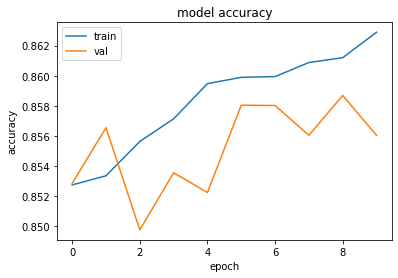

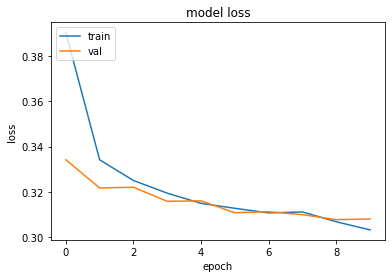

In [19]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("roberta-" + train_on + "-" + str(maxlen) +"-history-acc.png", transparent=False, pad_inches=0.1,  dpi=500)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("roberta-" + train_on + "-" + str(maxlen) + "-history-loss.png", transparent=False, pad_inches=0.1,  dpi=500)
plt.show()

# export

In [20]:
# select correct dataset
data_source = df.loc[(df['dataset'] != train_on)]
eval_on = data_source['dataset'].unique()

In [21]:
def convertIdToTag(x):
    return idx2tag[x]

In [22]:
# make evaluation on data and save everything to graphs
result = dict()
for data_set in eval_on:
    print(data_set)
    tmp = df.loc[(df['dataset'] == data_set)]
    
    ids = tmp["id"].to_numpy()
    X_pred = tmp["tokens"].to_numpy()
    y_true = tmp["target"].to_numpy()
    
    val_input_ids, val_input_masks, _ = tokenize(X_pred, tokenizer)

    y_pred = model.predict((val_input_ids, val_input_masks), verbose=1)

    for (y_p, y_t, mask, d_id) in zip(y_pred, y_true, val_input_masks, ids):
        prediction = np.argmax(y_p, axis=-1)
        values = np.array(list(map(convertIdToTag, prediction)))
        
        mask = list(map(bool,mask))
        final_prediction = values[mask]
        
        if len(final_prediction) == len(y_t):
            result[d_id] = {"predicted": final_prediction,"gold": y_t}

        #if np.count_nonzero(prediction) != 0:
        #    print(list(map(lambda x, y:(x,y), X_pred[i], values[mask])))

reman
23/23 [==============================] - 38s 2s/step
electoral_tweets
127/127 [==============================] - 218s 2s/step


In [23]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json_object = json.dumps(result, cls=NumpyEncoder)
with open("roberta-" + train_on + "-" + str(maxlen) + ".json", "w") as outfile:
    outfile.write(json_object)